## Kaggle Mercari Price Suggestion Challenge

### Data Preprocessing

In [2]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv("../mercari_train.tsv", sep="\t")
print(mercari_df.shape)
mercari_df.head()

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [3]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


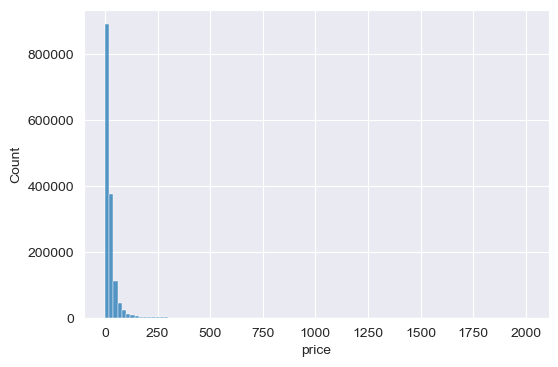

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

y_train_df = mercari_df["price"]
plt.figure(figsize=(6, 4))
sns.histplot(y_train_df, bins=100)
plt.show()

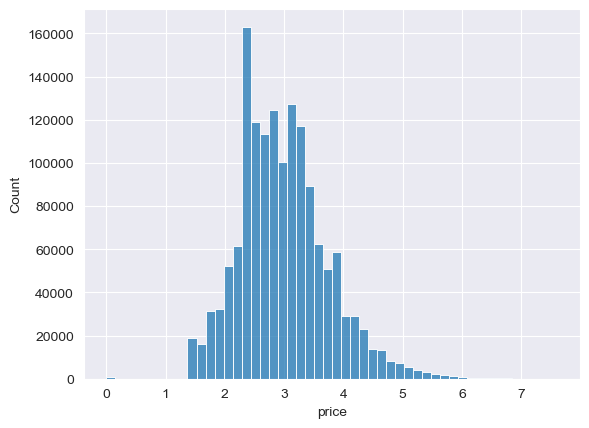

In [5]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df, bins=50)
plt.show()

In [6]:
mercari_df["price"] = np.log1p(mercari_df["price"])
mercari_df["price"].head()

0    2.397895
1    3.970292
2    2.397895
3    3.583519
4    3.806662
Name: price, dtype: float64

In [7]:
print("Shipping value type:\n", mercari_df["shipping"].value_counts())
print("item_condition_id value type:\n",
      mercari_df["item_condition_id"].value_counts())

Shipping value type:
 0    819435
1    663100
Name: shipping, dtype: int64
item_condition_id value type:
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


In [8]:
boolean_cond=mercari_df["item_description"] == "No description yet"
mercari_df[boolean_cond].count()

train_id             82489
name                 82489
item_condition_id    82489
category_name        81867
brand_name           45116
price                82489
shipping             82489
item_description     82489
dtype: int64

In [9]:
# large, medium, small 변환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ["Other_Null", "Other_Null", "Other_Null"]

mercari_df["cat_large"], mercari_df["cat_medium"], mercari_df["cat_small"] = \
zip(*mercari_df["category_name"].apply(lambda x: split_cat(x)))

print("large:", mercari_df["cat_large"].value_counts())
print("medium:", mercari_df["cat_medium"].value_counts())
print("small:", mercari_df["cat_small"].value_counts())

large: Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_large, dtype: int64
medium: Athletic Apparel        134383
Makeup                  124624
Tops & Blouses          106960
Shoes                   100452
Jewelry                  61763
                         ...  
Candles                     64
Ceramics and Pottery        57
Dolls and Miniatures        49
Books and Zines             46
Quilts                      31
Name: cat_medium, Length: 114, dtype: int64
small: Pants, Tights, Leggings       60177
Other                         50224
Face                          50171
T-Shirts                      46380
Shoes                         32168
                    

In [10]:
mercari_df["brand_name"] = mercari_df["brand_name"].fillna(value="Other_Null")
mercari_df["category_name"] = mercari_df["category_name"].fillna(value="Other_Null")
mercari_df["item_description"] = mercari_df["item_description"].fillna(value="Other_Null")

mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_large            0
cat_medium           0
cat_small            0
dtype: int64

In [11]:
print("brand name type counts:", mercari_df["brand_name"].nunique())
print("brand name 5 samples", mercari_df["brand_name"].value_counts()[:5])

brand name type counts: 4810
brand name 5 samples Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


In [13]:
print("name type counts:", mercari_df["name"].nunique())
print("name 10 samples", mercari_df["name"].value_counts()[:10])

name type counts: 1225273
name 10 samples Bundle                 2232
Reserved                453
Converse                445
BUNDLE                  418
Dress                   410
Coach purse             404
Lularoe TC leggings     396
Romper                  353
Nike                    340
Vans                    334
Name: name, dtype: int64


In [14]:
pd.set_option("max_colwidth", 200)

print("item_description average string size:", mercari_df["item_description"].str.len().mean())

mercari_df["item_description"][:2]

item_description average string size: 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

encoding and feature vectorization

In [15]:
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

In [16]:
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), stop_words="english")
X_descp = tfidf_descp.fit_transform(mercari_df["item_description"])

In [17]:
print("name vectorization shape:", X_name.shape)
print("item_description vectorization shape:", X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


In [19]:
from sklearn.preprocessing import LabelBinarizer


lb_brand_name= LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

lb_cat_large = LabelBinarizer(sparse_output=True)
X_cat_large = lb_cat_large.fit_transform(mercari_df['cat_large'])

lb_cat_medium = LabelBinarizer(sparse_output=True)
X_cat_medium = lb_cat_medium.fit_transform(mercari_df['cat_medium'])

lb_cat_small = LabelBinarizer(sparse_output=True)
X_cat_small = lb_cat_small.fit_transform(mercari_df['cat_small'])

In [20]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_large shape:{1}'.format(X_shipping.shape, X_cat_large.shape))
print('X_cat_medium shape:{0}, X_cat_small shape:{1}'.format(X_cat_medium.shape, X_cat_small.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand_shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_large shape:(1482535, 11)
X_cat_medium shape:(1482535, 114), X_cat_small shape:(1482535, 871)


In [21]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
                      X_shipping, X_cat_large, X_cat_medium, X_cat_small)

X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 161569)


11792

RMSLE 방식 평가

In [22]:
def rmsle(y, y_prd):
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_prd), 2)))

def evaluate_org_price(y_test, prds):
    prds_exmpm = np.expm1(prds)
    y_test_exmpm = np.expm1(y_test)

    rmsle_result = rmsle(y_test_exmpm, prds_exmpm)
    return rmsle_result

In [23]:
import gc
from  scipy.sparse import hstack

def model_train_predict(model,matrix_list):
    X= hstack(matrix_list).tocsr()

    X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'],
                                                        test_size=0.2, random_state=156)

    # fit & predict
    model.fit(X_train , y_train)
    prds = model.predict(X_test)

    del X , X_train , X_test , y_train
    gc.collect()

    return prds , y_test

In [26]:
linear_model = Ridge(solver="lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id, X_shipping,
                      X_cat_large, X_cat_medium, X_cat_small)
linear_prds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print("rmsle value if Item Description excluded:", evaluate_org_price(y_test, linear_prds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping, X_cat_large, X_cat_medium, X_cat_small)
linear_prds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print("rmsle value:", evaluate_org_price(y_test, linear_prds))

rmsle value if Item Description excluded: 0.5016517491617655
rmsle value: 0.4707521846202186


In [27]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping,
                      X_cat_large, X_cat_medium, X_cat_small)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_prds, y_test = model_train_predict(model=lgbm_model, matrix_list=sparse_matrix_list)
print("LightGBM rmsle value:", evaluate_org_price(y_test, lgbm_prds))

LightGBM rmsle value: 0.456526857278931


In [28]:
prds = lgbm_prds * 0.45 + linear_prds * 0.55
print("ensembled final rmsle value:", evaluate_org_price(y_test, prds))

ensembled final rmsle value: 0.4502033489250669
